In [1]:
from rms import Star, Planet, Spot, STSP

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u


In [201]:
(0.7266/100)**0.5

0.08524083528450434

In [251]:
planet = Planet(per=1.51087637, t0=2450000 + 7322.51654, inc=89.56, a=20.56, rp=0.05, #(0.7266/100)**0.5, 
                duration=36.19/60/24, b=0, lam=0*u.deg, ecc=0, w=90)
planet.limb_dark = 'quadratic'
planet.u = [0, 0]
planet.fp = 0
planet.t_secondary = None

In [252]:
from astropy.constants import R_sun, M_sun, G

rho_sun = M_sun / (4/3 * np.pi * R_sun**3)

rho_star = 47.00335066 * rho_sun
rho_star_upper = (rho_star + 4.2*rho_sun)

In [253]:

ars = float((rho_star * G * (planet.per * u.day)**2 / 3 / np.pi)**(1/3))
ars_upper = float((rho_star_upper * G * (planet.per * u.day)**2 / 3 / np.pi)**(1/3))
ars_err = ars_upper - ars
ars, ars_err

(19.997084540980982, 0.5787063286409762)

In [260]:
import astropy.units as u
from astropy.time import Time

star = Star(planet=planet, rotation_period=30*u.day, spot_contrast=0., inc_stellar=90, u=[0.1, 0.0],
            rho_s=float(rho_star/rho_sun))
spots = [Spot(89.9*u.deg, 0*u.deg, 0.9),
         Spot(-89.9*u.deg, 0*u.deg, 0.9)]
# spots = [Spot(0*u.deg, 0*u.deg, 0.9)]

times = Time(np.linspace(planet.t0-0.017, planet.t0+0.017, 5000), format='jd')

with STSP(times, star, spots, keep_dir=False) as stsp: 
    lc = stsp.generate_lightcurve(normalize_oot=True)

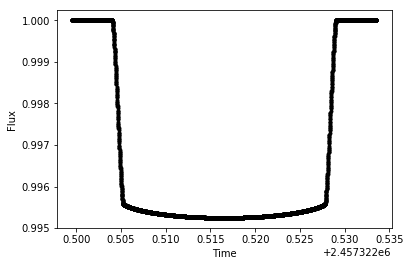

In [261]:
lc.plot()

In [262]:
times = lc.times.jd
flux = lc.fluxes
yerr = 0.000767

In [263]:
from copy import deepcopy
import robin

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

def aRs_i(p0, T14, b, transit_params):
    """
    Convert from duration and impact param to a/Rs and inclination

    Parameters
    ----------
    transit_params : `batman.TransitParams`
        Transit parameters
    Returns
    -------
    aRs : float
        Semi-major axis in units of stellar radii
    i : float
        Orbital inclination in degrees
    """
    eccentricity = transit_params.ecc
    omega = transit_params.w
    P = transit_params.per

    # Eccentricity term for b -> a/rs conversion
    beta = (1 - eccentricity**2)/(1 + eccentricity*np.sin(np.radians(omega)))

    # Eccentricity term for duration equation:
    c = (np.sqrt(1 - eccentricity**2) /
         (1 + eccentricity*np.sin(np.radians(omega))))

    i = np.arctan(beta * np.sqrt((1 + p0)**2 - b**2) /
                  (b * np.sin(T14*np.pi / (P*c))))
    aRs = b/(np.cos(i) * beta)
    return aRs, np.degrees(i)

def transit_model(theta, x):
    r0, r1, q1, q2, a, inc, f0, t0 = theta
    trial_params = deepcopy(planet)
    trial_params.p0 = r0
    trial_params.p1 = r1
    trial_params.t0 = t0
    trial_params.u = kipping_to_quadratic([q1, q1])

#     a, inc = aRs_i(r0, t14, b, trial_params)
    trial_params.a = a
    trial_params.inc = inc
    
    m = robin.TransitModel(trial_params, x, exp_time=times[1]-times[0], supersample_factor=3)
    fluxes = f0 * m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, q1, q2, a, inc, f0, t0 = theta

    model = transit_model(theta, x) 
    return -0.5*(np.sum((model - y)**2 / yerr**2))


def lnprior(theta):
    r0, r1, q1, q2, a, inc, f0, t0 = theta

    if (0.01 < r0 < 0.2 and 0.01 < r1 < 0.2 and 0 < f0 < 1.5 and 
        1 < a < 100 and 80 < inc < 90 and 0 < q1 < 1 and 0 < q2 < 1) and planet.t0-0.02 < t0 < planet.t0+0.02:
        return -0.5 * ((a - ars)/ars_err)**2
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 8, 16
pos = []

q1 = 0.1
q2 = 0

while len(pos) < nwalkers: 
    trial_pos = [planet.rp, planet.rp, q1, q2, planet.a, planet.inc, 1, planet.t0] + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, flux, yerr),
                                threads=8)

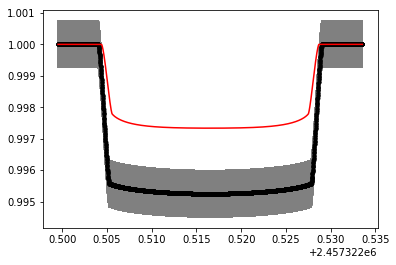

In [264]:
init_f = transit_model([planet.rp, planet.rp, q1, q2, planet.a, planet.inc, 1, planet.t0], times)

plt.errorbar(times, flux, yerr, fmt='.', color='k', ecolor='gray')
plt.plot(times, init_f, 'r', zorder=10)

In [265]:
sampler.run_mcmc(pos, 2000); 

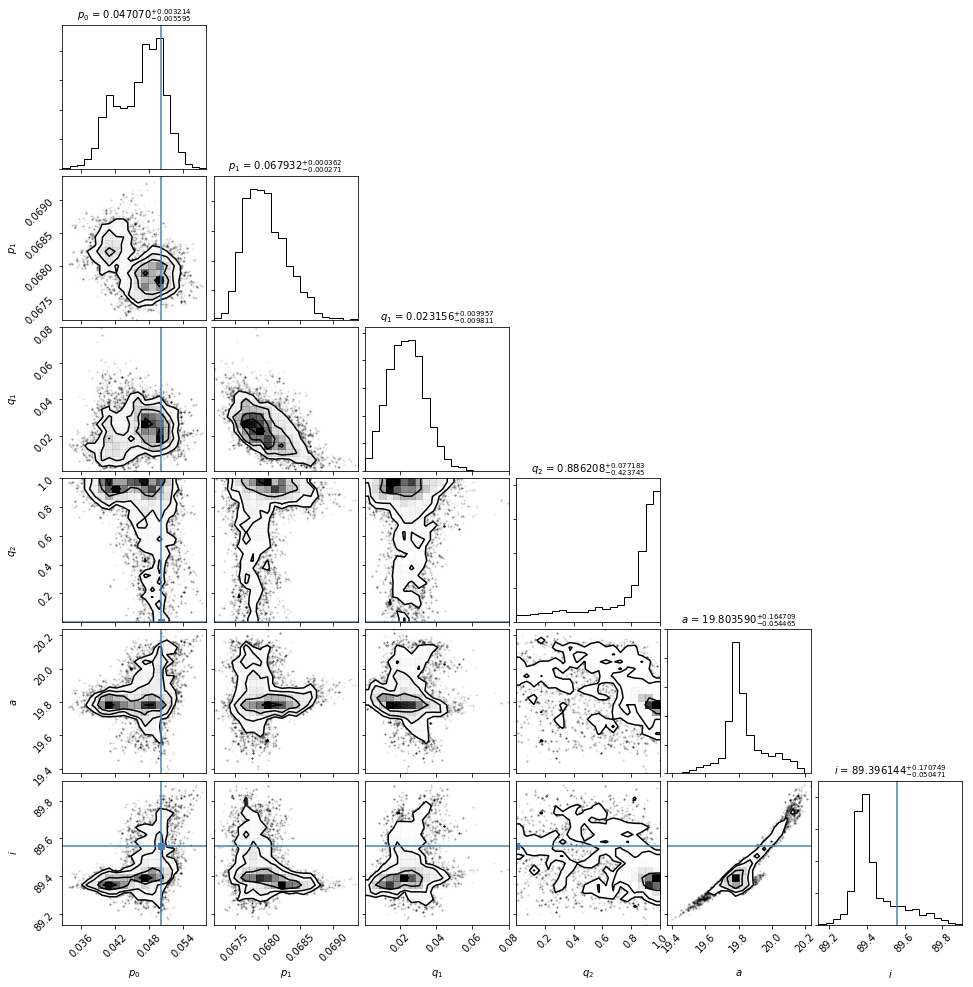

In [266]:
from corner import corner

corner(sampler.chain[:, 1000:, :-2].reshape((-1, ndim-2)), truths=[planet.rp, planet.rp, q1, q2, planet.a, planet.inc], 
       labels=['$p_0$', '$p_1$', '$q_1$', '$q_2$', '$a$', '$i$'], show_titles=True, #fig=fig, 
       title_fmt='.6f', title_kwargs=dict(fontsize=10));
plt.savefig('corner_full_rms.pdf', bbox_inches='tight')

In [267]:
# np.savetxt('rms_samples.txt', sampler.flatchain)

# class S(object):
#     def __init__(self):
#         self.flatchain = None
    
#     @property
#     def chain(self, ndim=ndim, nwalkers=nwalkers):
#         return self.flatchain.reshape((nwalkers, 10000, ndim))
    
# sampler = S()

# sampler.flatchain = np.loadtxt('trappist1b_samples.txt')

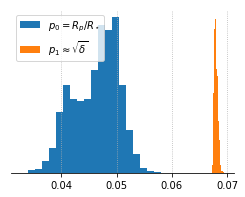

In [268]:
fig, ax = plt.subplots(figsize=(4, 3))

fmax = 0
for p, label in zip(sampler.chain[:, 1000:, :2].reshape((-1, 2)).T, 
                    ['$p_0 = R_p/R_\star$', r'$p_1 \approx \sqrt{\delta}$']):
    n, _, _ = plt.hist(p, bins=20, histtype='stepfilled', label=label)
ax.grid(ls=':')
ax.legend()
ax.set(yticks=[])


for s in ['right', 'top', 'left']:
    ax.spines[s].set_visible(False)
plt.savefig('rms_agreement.pdf', bbox_inches='tight')